# Assignment 1: Benchmarking Neural Nets with the XOR Problem

### DS 6050 - School of Data Science - University of Virginia
In this assignment, you will implement your own neural networks to classify non-linear data from the XOR dataset. For deliverables, you must write code in Python/Tensorflow and submit **this** Jupyter Notebook file (.ipynb) to earn a total of 80 pts. Note that you must save your Notebook filename under this format: **yourUvaUserId_assignment_1_ann.ipynb**.



In [1]:
# You might want to use the following packages
import numpy as np
import pandas as pd
import os
import tensorflow as tf

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from functools import partial

---
# Generate Data

Generate an XOR dataset and split 

(720, 2)
(200, 2)
(80, 2)


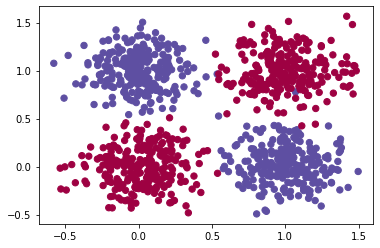

In [3]:
def make_xor(n_points):
    centers = np.array([[0,0],[0,1],[1,0],[1,1]])
    labels = np.array([0,1,1,0])
    data = np.array([]).reshape(-1,3)
    for center, label in zip(centers,labels):
        points = np.random.normal(loc=center,scale=0.2,size=(n_points//4,2))
        points_labels = np.hstack((points,label*np.ones(n_points//4).reshape((-1, 1))))
        data = np.vstack((data,points_labels))
    return (data[:,[0,1]],data[:,2])


X, y = make_xor(1000)
y=y.astype(np.int64)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=49)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size= 0.1, random_state=49) 
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

---
## Simple ANN using Keras

Use the standard libarary of Neural Net on the training data, and then test the classifier on the test data. You will create a simple ANN with 3 layers: an Input Layer, a Hidden Layer and an Output Layer. For each layer, you can specify the number of nodes appropriate for the XOR problem. Also, feel free to tune the network as you see fit. You have to report the accuracy of the network on the validation set.

In [4]:
import tensorflow as tf
from tensorflow import keras

my_model = keras.models.Sequential()
my_model.add(keras.layers.Dense(4, input_dim=2, activation='relu'))
# my_model.add(keras.layers.Dense(2, activation='relu'))
my_model.add(keras.layers.Dense(2, activation='softmax'))

# Compile model
my_model.compile(loss="sparse_categorical_crossentropy",
                optimizer="sgd",
                metrics=["accuracy"])

# Train model
history = my_model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_val, y_val))

Epoch 1/30
23/23 [==============================] - 1s 11ms/step - loss: 0.7195 - accuracy: 0.5597 - val_loss: 0.6787 - val_accuracy: 0.7125
Epoch 2/30
23/23 [==============================] - 0s 3ms/step - loss: 0.7047 - accuracy: 0.6639 - val_loss: 0.6752 - val_accuracy: 0.7375
Epoch 3/30
23/23 [==============================] - 0s 3ms/step - loss: 0.6946 - accuracy: 0.6917 - val_loss: 0.6733 - val_accuracy: 0.7250
Epoch 4/30
23/23 [==============================] - 0s 3ms/step - loss: 0.6868 - accuracy: 0.6931 - val_loss: 0.6722 - val_accuracy: 0.7000
Epoch 5/30
23/23 [==============================] - 0s 3ms/step - loss: 0.6812 - accuracy: 0.6667 - val_loss: 0.6714 - val_accuracy: 0.6500
Epoch 6/30
23/23 [==============================] - 0s 2ms/step - loss: 0.6767 - accuracy: 0.6264 - val_loss: 0.6709 - val_accuracy: 0.5625
Epoch 7/30
23/23 [==============================] - 0s 3ms/step - loss: 0.6726 - accuracy: 0.5861 - val_loss: 0.6705 - val_accuracy: 0.5250
Epoch 8/30
23/23 [=

In [19]:
_, accuracy = my_model.evaluate(X_val, y_val)

3/3 [==============================] - 0s 2ms/step - loss: 0.5468 - accuracy: 0.8625


- - -
# Implementation of my own neural network


In [2]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import OneHotEncoder

class MyNeuralNet(BaseEstimator):

    def __init__ (self, n0, n1, n2, alpha=0.01):
        """
        @param: n0: Number of nodes in the input layer
        @param: n1: Number of nodes in the hidden layer
        @param: n2: Number of nodes in the output layer
        @param: alpha: The Learning Rate
        """

        # SUBTASK 1: Initialize the parameters to random values.
        np.random.seed(42)
        self.W1 = np.random.normal(loc=0, scale=1, size=(n1, n0))
        self.b1 = np.random.normal(loc=0, scale=1, size=(n1, 1))
        self.W2 = np.random.normal(loc=0, scale=1, size=(n2, n1))
        self.b2 = np.random.normal(loc=0, scale=1, size=(n2, 1))

        # Configure the learning rate
        self.alpha = alpha
        # One-hot encoder for labels
        self.encoder = OneHotEncoder(sparse=False)
        
    def forward_pass(self, X):
        """
        Pass the signal forward through the layers.
        @param: X: feature
        @return: A1: saved value of the output of the hidden layer
        @return: A2: activated return value of the output layer.
        """

        # Uses tanh activation and a softmax layer
        Z1 = np.matmul(self.W1, X) + self.b1
        A1 = np.tanh(Z1)
        Z2 = np.matmul(self.W2, A1) + self.b2
        A2 = tf.nn.softmax(Z2.T).numpy().T
        
        return A1, A2


    def loss(self, X, y):
        """
        Evaluate the total loss on the dataset
        @param: X: features
        @param: y: labels
        @return: L: the loss value
        """

        # Uses cross entropy loss
        A1, A2 = self.forward_pass(X)  
        Y = self.one_hot(y)
        L = np.mean(-np.sum(Y*np.log(A2), axis=0))

        return L

    def backward_pass(self, A1, A2, X, y):
        """
        @param: X: feature
        @param: y: label
        @param: A1: saved value of the output of the hidden layer
        @param: a2: activated return value of the output layer.

        @return: dW1: the loss gradient of W1
        @return: db1: the loss gradient of b1
        @return: dW2: the loss gradient of W2
        @return: db2: the loss gradient of b2
        """

        # Ref document: https://deepnotes.io/softmax-crossentropy
        m   = y.shape[0]
        dZ2 = A2 - self.one_hot(y) 
        dW2 = np.dot(dZ2, A1.T)/m
        db2 = np.sum(dZ2, axis=1, keepdims=True)/m
        dZ1 = np.multiply( np.dot( self.W2.T, dZ2), 1-np.power( A1, 2))
        dW1 = np.dot(dZ1, X.T)/m
        db1 = np.sum(dZ1, axis=1, keepdims=True)/m

        return dW1, db1, dW2, db2


    def fit(self, X, y , epochs, X_val, Y_val):
        """
        Learns parameters for the neural network and returns the model.
        
        @param: X: the training feature
        @param: y: the train label
        @param: epochs: Number of passes through the training data for gradient descent
        @param: X_val: the feature of validation set
        @param: y_val: the label of validation set
        """

        # Input checks: X and X_val needs to be in the form of n0 x m
        if (X.shape[0] > X.shape[1]): X = X.T
        if (X_val.shape[0] > X_val.shape[1]): X_val = X_val.T

        # Gradient descent
        for i in range(0, epochs):
            
            # Step 1: Forward pass
            A1, A2 = self.forward_pass(X)
            
            # Step 2: Backward pass
            dW1, db1, dW2, db2 = self.backward_pass(A1, A2, X, y)

            # Step 3: Gradient Descent 
            self.W1 -= self.alpha*dW1
            self.b1 -= self.alpha*db1
            self.W2 -= self.alpha*dW2
            self.b2 -= self.alpha*db2

            # Print the loss and validation accuracy every 10 epochs.
            if i % 5 == 0:
                print("Epoch %i/%i - loss: %f - accuracy: %f - val_loss: %f - val_accuracy: %f" 
                      %(i,epochs, self.loss(X, y), self.evaluate(X, y),
                        self.loss(X_val, y_val), self.evaluate(X_val,y_val)))

    def predict(self, X):
        """
        Predict label vector y
        """
        # check X for the form of n0 x m
        if (X.shape[0] > X.shape[1]): X = X.T
        
        f = self.forward_pass(X)[1]
        y_hat = np.argmax(f, axis=0)

        return y_hat


    def evaluate(self, X, y):
        """
        Evaluate the accuracy of the model
        """
        m = y.shape[0]
        y_hat = self.predict(X)
        correct_y = (y_hat == y).astype(int)

        return sum(correct_y)/m


    def one_hot(self, y):
        """
        Utility function: Convert a label vector to one-hot vector
        """
        Y = self.encoder.fit_transform(y.reshape(len(y),1))  
        return Y.T # Transpose to get into same shape 1 x m


    def plot_decision_boundary(self, X, y):
        """
        Utility Function: Plot a decision boundary for visualization purpose.
        """
        # Set min and max values and give it some padding
        x_min, x_max = X[:,0].min() - .5, X[:,0].max() + .5
        y_min, y_max = X[:,1].min() - .5, X[:,1].max() + .5
        h = 0.01
        # Generate a grid of points with distance h between them
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        # Predict the function value for the whole gid
        data_grid= np.c_[xx.ravel(), yy.ravel()]
        Z = self.predict(data_grid)
        Z = Z.reshape(xx.shape)

        # Plot the contour and training examples
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)
        plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.Spectral)        

## Model 1

Epoch 0/100 - loss: 0.714998 - accuracy: 0.511111 - val_loss: 0.732830 - val_accuracy: 0.475000
Epoch 5/100 - loss: 0.668583 - accuracy: 0.669444 - val_loss: 0.685791 - val_accuracy: 0.600000
Epoch 10/100 - loss: 0.632330 - accuracy: 0.647222 - val_loss: 0.643617 - val_accuracy: 0.637500
Epoch 15/100 - loss: 0.590931 - accuracy: 0.750000 - val_loss: 0.600055 - val_accuracy: 0.725000
Epoch 20/100 - loss: 0.552984 - accuracy: 0.738889 - val_loss: 0.554076 - val_accuracy: 0.762500
Epoch 25/100 - loss: 0.518467 - accuracy: 0.831944 - val_loss: 0.525309 - val_accuracy: 0.812500
Epoch 30/100 - loss: 0.495915 - accuracy: 0.716667 - val_loss: 0.468524 - val_accuracy: 0.775000
Epoch 35/100 - loss: 0.588085 - accuracy: 0.513889 - val_loss: 0.674212 - val_accuracy: 0.412500
Epoch 40/100 - loss: 0.455363 - accuracy: 0.713889 - val_loss: 0.414814 - val_accuracy: 0.787500
Epoch 45/100 - loss: 0.492630 - accuracy: 0.725000 - val_loss: 0.561288 - val_accuracy: 0.625000
Epoch 50/100 - loss: 0.420360 - 

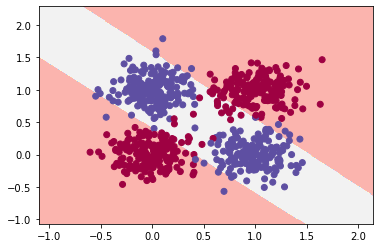

In [58]:
n0 = 2 # input layer dimensionality
n1 = 2 # hiden layer dimensionality
n2 = 2 # output layer dimensionality
alpha = 1 # learning rate for gradient descent
epochs = 100 # number of iteration/epochs

# Build a model with 3 layers
myModel1 = MyNeuralNet(n0, n1, n2, alpha);
myModel1.fit(X_train, y_train, epochs, X_val, y_val)
print("Accuracy on the test set is ", myModel1.evaluate(X_test, y_test))

# Plot the decision boundary
myModel1.plot_decision_boundary(X_train, y_train)

## Model 2

Epoch 0/100 - loss: 0.658007 - accuracy: 0.423611 - val_loss: 0.658798 - val_accuracy: 0.412500
Epoch 5/100 - loss: 0.545446 - accuracy: 0.813889 - val_loss: 0.566354 - val_accuracy: 0.762500
Epoch 10/100 - loss: 0.482492 - accuracy: 0.886111 - val_loss: 0.489613 - val_accuracy: 0.900000
Epoch 15/100 - loss: 0.422047 - accuracy: 0.927778 - val_loss: 0.426519 - val_accuracy: 0.937500
Epoch 20/100 - loss: 0.367791 - accuracy: 0.926389 - val_loss: 0.367102 - val_accuracy: 0.950000
Epoch 25/100 - loss: 0.322846 - accuracy: 0.941667 - val_loss: 0.328016 - val_accuracy: 0.950000
Epoch 30/100 - loss: 0.292695 - accuracy: 0.920833 - val_loss: 0.273771 - val_accuracy: 0.950000
Epoch 35/100 - loss: 0.323695 - accuracy: 0.895833 - val_loss: 0.387254 - val_accuracy: 0.837500
Epoch 40/100 - loss: 0.314791 - accuracy: 0.865278 - val_loss: 0.254686 - val_accuracy: 0.912500
Epoch 45/100 - loss: 0.212266 - accuracy: 0.948611 - val_loss: 0.232170 - val_accuracy: 0.925000
Epoch 50/100 - loss: 0.189277 - 

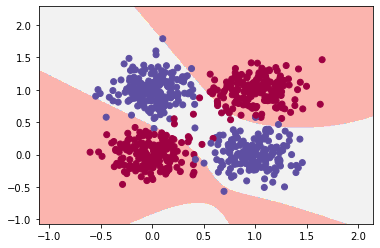

In [60]:
n0 = 2 # input layer dimensionality
n1 = 4 # hiden layer dimensionality
n2 = 2 # output layer dimensionality
alpha = 1 # learning rate for gradient descent
epochs = 100 # number of iteration/epochs

# Build a model with 3 layers
myModel2 = MyNeuralNet(n0, n1, n2, alpha);
myModel2.fit(X_train, y_train, epochs, X_val, y_val)
print("Accuracy on the test set is ", myModel1.evaluate(X_test, y_test))

# Plot the decision boundary
myModel2.plot_decision_boundary(X_train, y_train)

## Model 3

Epoch 0/100 - loss: 1.077083 - accuracy: 0.709722 - val_loss: 0.972232 - val_accuracy: 0.712500
Epoch 5/100 - loss: 1.974989 - accuracy: 0.513889 - val_loss: 2.303737 - val_accuracy: 0.412500
Epoch 10/100 - loss: 1.368776 - accuracy: 0.637500 - val_loss: 1.093401 - val_accuracy: 0.712500
Epoch 15/100 - loss: 1.143649 - accuracy: 0.534722 - val_loss: 1.401694 - val_accuracy: 0.437500
Epoch 20/100 - loss: 0.128924 - accuracy: 0.954167 - val_loss: 0.096004 - val_accuracy: 0.962500
Epoch 25/100 - loss: 0.060213 - accuracy: 0.983333 - val_loss: 0.053775 - val_accuracy: 1.000000
Epoch 30/100 - loss: 0.055155 - accuracy: 0.983333 - val_loss: 0.048874 - val_accuracy: 0.975000
Epoch 35/100 - loss: 0.051601 - accuracy: 0.981944 - val_loss: 0.045191 - val_accuracy: 0.987500
Epoch 40/100 - loss: 0.048904 - accuracy: 0.983333 - val_loss: 0.042309 - val_accuracy: 0.987500
Epoch 45/100 - loss: 0.046768 - accuracy: 0.983333 - val_loss: 0.039984 - val_accuracy: 0.987500
Epoch 50/100 - loss: 0.045028 - 

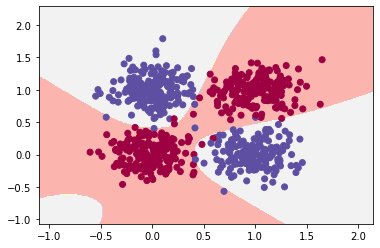

In [62]:
n0 = 2 # input layer dimensionality
n1 = 10 # hiden layer dimensionality
n2 = 2 # output layer dimensionality
alpha = 3 # learning rate for gradient descent
epochs = 100 # number of iteration/epochs

# Build a model with 3 layers
myModel3 = MyNeuralNet(n0, n1, n2, alpha);
myModel3.fit(X_train, y_train, epochs, X_val, y_val)
print("Accuracy on the test set is ", myModel3.evaluate(X_test, y_test))

# Plot the decision boundary
myModel3.plot_decision_boundary(X_train, y_train)

# COMPARISONS OF THESE MODELS WITH THE STANDARD LIBRARY MODEL

In [51]:
my_model.evaluate(X_val, y_val)

3/3 [==============================] - 0s 2ms/step - loss: 0.5633 - accuracy: 0.9625


[0.5632807612419128, 0.9624999761581421]

In [78]:
myModel1.evaluate(X_val, y_val)

0.9125

In [80]:
myModel2.evaluate(X_val, y_val)

0.9625

In [79]:
myModel3.evaluate(X_val, y_val)

1.0